Put on the family Centre 

Currently no requirement for it to be contingent

Test file for Wellington Dynamic DEM

# File Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import datetime
import pyproj
import rioxarray
from scipy.interpolate import griddata
import scipy as sp
import folium
import os
import folium
from ipywidgets import interact, Dropdown
from IPython.display import display, clear_output

In [2]:
df_shoreline = pd.read_csv('linzcoast 1.dat',header=None,delimiter=' ')

In [3]:
df_shoreline.columns = ['lon','lat']

In [4]:
df_shoreline.dropna(axis=0,inplace=True)

In [5]:
# Define the current and target CRS using EPSG codes
current_crs = pyproj.CRS("EPSG:2193")  
target_crs = pyproj.CRS("EPSG:4326")

transformer = pyproj.Transformer.from_crs(current_crs, target_crs, always_xy=True,allow_ballpark=False)

# target_crs = pyproj.CRS("EPSG:4167")
# transformer_2 = pyproj.Transformer.from_crs(current_crs, target_crs, always_xy=True)

# Storm Surge

In [6]:
df_storm_surge = pd.read_csv('storm_surge.csv')

In [7]:
df_storm_surge['month'] = [x.split(' ')[0].split('/')[1] for x in df_storm_surge.datetime]
df_storm_surge['year'] = [x.split(' ')[0].split('/')[-1] for x in df_storm_surge.datetime]

In [8]:
df_storm_surge

,lat,lng,datetime,height,month,year
0,-41.25,174.5,1/01/2010 12:00,-0.034448,01,2010
1,-41.25,174.5,2/01/2010 12:00,0.062858,01,2010
2,-41.25,174.5,3/01/2010 12:00,0.096683,01,2010
3,-41.25,174.5,4/01/2010 12:00,0.014322,01,2010
4,-41.25,174.5,5/01/2010 12:00,-0.034867,01,2010
...,...,...,...,...,...,...
131483,-41.50,175.0,27/12/2099 12:00,-0.013351,12,2099
131484,-41.50,175.0,28/12/2099 12:00,-0.026677,12,2099
131485,-41.50,175.0,29/12/2099 12:00,-0.008993,12,2099
131486,-41.50,175.0,30/12/2099 12:00,0.014627,12,2099


In [9]:
df_annual_storm_surge = df_storm_surge[['year','height']].groupby('year').mean()

In [10]:
df_annual_storm_surge = df_annual_storm_surge.astype(float)
df_annual_storm_surge.index = df_annual_storm_surge.index.astype(float)

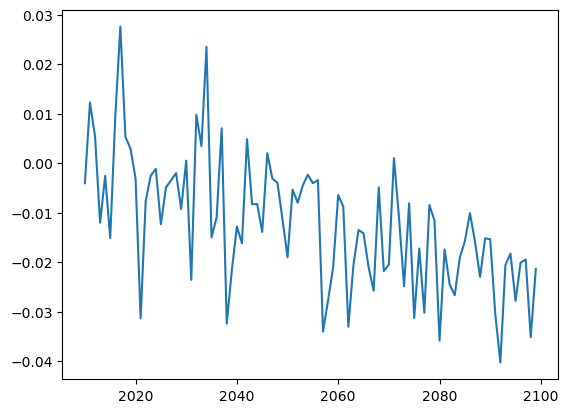

In [11]:
plt.plot(df_annual_storm_surge)

# Load DEM

In [12]:
# df_vlms = pd.read_csv('our-changing-coast-insar_rates_searise.csv')
xr_dem = rioxarray.open_rasterio('dem_8m_2012_wgs//92L94-92L34.tif')

In [13]:
dem_values = xr_dem.values
fill_value = np.min(dem_values)

dem_values[dem_values==fill_value] = np.nan
xr_dem.values = dem_values

In [14]:
# Create a regular grid of coordinates
res = 500 # low res to make the initial calcs fast
x_regular = np.linspace(xr_dem['x'].min(), xr_dem['x'].max(), res)
y_regular = np.linspace(xr_dem['y'].min(), xr_dem['y'].max(), res)

# Interpolate data onto regular grid
data_interpolated = xr_dem[0,:,:].interp(y=y_regular, x=x_regular)

# Now you can use the interpolated data for transformation
new_DEM = xr.DataArray(data_interpolated,coords={"y":y_regular,"x":x_regular},dims=["y","x"])

# Load VLMs

In [15]:
df_vlms = pd.read_csv('Welly_VLM_2018-2023_100m.txt',delimiter='\t')
df_vlms = df_vlms.astype(float)

In [16]:
df_vlms = df_vlms.rename(columns={'  0.000000':'lon','  0.000000.1':'lat'})

In [17]:
df_vlms.set_index(['lat','lon'],inplace=True)
df_vlms.columns = df_vlms.columns.astype(float)
df_vlms = df_vlms.reset_index()

In [18]:
cols = [x for x in df_vlms.columns if x not in ['lon','lat']]

In [19]:
x = new_DEM.x#np.linspace(df_vlms['lon'].min(), df_vlms['lon'].max(), 100)
y = new_DEM.y#np.linspace(df_vlms['lat'].min(), df_vlms['lat'].max(), 100)

X, Y = np.meshgrid(x, y)

example_year = 2018
Z = griddata((df_vlms['lon'], df_vlms['lat']), df_vlms[2018.0], (X, Y), method='linear')
Z = np.nan_to_num(Z,nan=0)

Z_nax = Z[:,:,np.newaxis]
duplicated_arr = np.broadcast_to(Z_nax, (*Z.shape, len(cols)))
duplicated_arr = duplicated_arr.copy()
# new array has dims of lon,lat,time

i = 0
for year in cols:
    duplicated_arr[:,:,i] = griddata((df_vlms['lon'], df_vlms['lat']), df_vlms[year], (X, Y), method='linear')
    i+=1

xr_vlms = xr.DataArray(duplicated_arr,coords={"lon":np.array(x),"lat":np.array(y),"years":cols},dims=['lon','lat','years'])

xr_vlm_interp1 = xr_vlms.interpolate_na(dim='lat',method='linear')
xr_vlm_interp2 = xr_vlms.interpolate_na(dim='lon',method='linear')

xr_vlm_interp = (xr_vlm_interp1+xr_vlm_interp2)/2

# Load SLR Data

In [20]:
xr_slr = sp.io.loadmat('../../Ian_relabelled_sites/total_volc_noVLMssp585_low_confidence_values.mat')

lats = {x:y for x,y in zip(xr_slr['locations'].squeeze(),xr_slr['lat'].squeeze())}
lons = {x:y for x,y in zip(xr_slr['locations'].squeeze(),xr_slr['lon'].squeeze())}

x = new_DEM.x
y = new_DEM.y

years = np.unique(xr_slr['years'])
quantiles = [0.17,0.5,0.83]

X, Y = np.meshgrid(x, y)

example_year = np.min(years)
example_quantile = np.min(quantiles)

In [21]:
file_names = os.listdir("../../Ian_relabelled_sites/")
file_names = [x for x in file_names if ('total' in x)&('low' in x)&('_noVLM' in x)]

In [22]:
duplicated_array = np.zeros((len(x),len(y),len(years),len(quantiles),len(file_names)))

In [23]:
k = 0
for file in file_names:
    xr_slr = sp.io.loadmat(f'../../Ian_relabelled_sites/{file}')
    
    xr_slr = xr.DataArray(xr_slr['sea_level_change'],
                          coords={'locations':xr_slr['locations'].squeeze(),'years':xr_slr['years'].squeeze(),'quantiles':xr_slr['quantiles'].squeeze()},
                         dims=['locations','years','quantiles'])
    
    df_slr = xr_slr.sel(quantiles=quantiles).to_dataframe('slr')
    
    df_slr['Lat'] = [lats[x] for x in df_slr.reset_index()['locations']]
    df_slr['Lon'] = [lons[x] for x in df_slr.reset_index()['locations']]
    
    # Focus on the wellington region
    df_slr = df_slr[(df_slr.Lon>np.min(new_DEM.x.values))&(df_slr.Lat>np.min(new_DEM.y.values))&(df_slr.Lon<np.max(new_DEM.x.values))&(df_slr.Lat<np.max(new_DEM.y.values))]
    
    df_slr = df_slr.reset_index().drop('locations',axis=1)
    
    i = 0
    for year in years:
        j = 0
        for quantile in quantiles:
            df_slr_inst = df_slr[(df_slr.years==year)&(df_slr.quantiles==quantile)]
            duplicated_array[:,:,i,j,k] = griddata((df_slr_inst['Lon'], df_slr_inst['Lat']), df_slr_inst['slr'], (X, Y), method='linear')
            j+=1
        i+=1
    k+=1

xr_slr = xr.DataArray(duplicated_array,coords={"Lon":np.array(x),"Lat":np.array(y),"years":years,"quantiles":quantiles,"scenarios":file_names},dims=['Lon','Lat','years','quantiles','scenarios'])

filled_x = xr_slr.ffill('Lon').bfill('Lat')
filled_y = xr_slr.ffill('Lat').bfill('Lon')
xr_slr_filled = (filled_x+filled_y)/2
    

# Adding SLR and VLM together Data

In [24]:
# Find a mean of the rates and project forward
xr_vlm_mean = xr_vlm_interp.mean(dim='years',skipna=True)
xr_vlm_mean = xr_vlm_mean.expand_dims({'years':xr_slr.years.values})

year_count = (xr_vlm_mean.years-np.min(xr_vlm_mean.years)) #should really start when the DEM was made for
xr_vlm_forecast = xr_vlm_mean*np.array(year_count)[:,None,None]
xr_vlm_forecast = xr_vlm_forecast.transpose('lon','lat','years')
xr_slr_vlm_adjusted = xr_slr_filled-np.array(xr_vlm_forecast)[:,:,:,None,None]

# Flooding the DEM

In [25]:
new_DEM_mask = new_DEM.copy()
new_DEM_mask = new_DEM_mask/new_DEM_mask
new_DEM_mask = new_DEM_mask.fillna(123456789)#where(new_DEM_mask!=float('NaN'),123456789)
new_DEM_mask = new_DEM_mask.where(new_DEM_mask!=1,np.nan)
new_DEM_mask = new_DEM_mask.where(new_DEM_mask!=123456789,1)

In [26]:
masked_array_dict = {}
flooded_dict = {}

for year in years:
    for scenario in file_names:
        xr_slr_vlm_adjusted_year = xr_slr_vlm_adjusted.sel(years=year,scenarios=scenario)
        
        new_DEM_flooded_low = new_DEM-np.array(xr_slr_vlm_adjusted_year.sel(quantiles=np.min(quantiles)))/1000
        new_DEM_flooded_low = new_DEM_flooded_low
        flooded_low = new_DEM_flooded_low.where(new_DEM_flooded_low<0,np.nan)*0+1
        
        new_DEM_flooded_mid = new_DEM-np.array(xr_slr_vlm_adjusted_year.sel(quantiles=0.5))/1000
        new_DEM_flooded_mid = new_DEM_flooded_mid
        flooded_mid = new_DEM_flooded_mid.where(new_DEM_flooded_mid<0,np.nan)*0+1
        
        new_DEM_flooded_high = new_DEM-np.array(xr_slr_vlm_adjusted_year.sel(quantiles=np.max(quantiles)))/1000
        new_DEM_flooded_high = new_DEM_flooded_high
        flooded_high = new_DEM_flooded_high.where(new_DEM_flooded_high<0,np.nan)*0+1
        
        flooded = flooded_low.fillna(0)+flooded_mid.fillna(0)+flooded_high.fillna(0)
        flooded = flooded.where(flooded>0,np.nan)
        
        masked_flooded = np.ma.masked_invalid(flooded)
        masked_flooded = (np.max(masked_flooded)-masked_flooded)/(np.max(masked_flooded)-np.min(masked_flooded))
        masked_flooded = masked_flooded[::-1,:]

        masked_array_dict.update({
            (year,scenario):masked_flooded
        })

        flooded_dict.update({
            (year,scenario):flooded
        })


# Visualise

In [27]:
cmap = plt.cm.get_cmap('brg')

wellington_coords = [-41.28664, 174.77557]
zoom = 11

def create_map(year,ssp):
    token = "pk.eyJ1Ijoic2hhbm5vbi1iZW5ndHNvbiIsImEiOiJja3F1Y2Q0dHEwMzYwMm9wYmtzYzk2bDZuIn0.5jGMyEiJdmXs1HL7x3ThPw" # your mapbox token
    tileurl = 'https://api.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}@2x.png?access_token=' + str(token)
    m = folium.Map(location=wellington_coords, zoom_start=zoom)
    custom_tile_layer = folium.TileLayer(tiles=tileurl, name='Satellite',attr='Mapbox',overlay=False).add_to(m)

    masked_flooded = masked_array_dict[(year,ssp)]
    flooded = flooded_dict[(year,ssp)]

    # print(year,ssp)
    
    folium.raster_layers.ImageOverlay(cmap(masked_flooded),
                                      [[flooded.y.values.min(), flooded.x.values.min()],
                                       [flooded.y.values.max(), flooded.x.values.max()]],opacity=.5).add_to(m)

    return(m)
    
# Define dropdown options
dropdown_options1 = ['ssp126', 'ssp585']
dropdown_options2 = years

# Define callback function to update map when dropdown value changes
def update_map(year, ssp):
    clear_output(wait=True)
    try:
        m = create_map(year, f'total_volc_noVLM{ssp}_low_confidence_values.mat')
        display(m)
    except Exception as e:
        print(f"Error occurred: {e}")

# Create interactive dropdowns
interact(update_map, year=dropdown_options2, ssp=dropdown_options1)


C:\Users\shannonb\AppData\Local\Temp\ipykernel_6400\1785278694.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('brg')


interactive(children=(Dropdown(description='year', options=(2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 21…

<function __main__.update_map(year, ssp)>